**Check Google Collab resource**

In [1]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May  6 14:26:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# If using TPU as accelerator
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
# Check RAM usage
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


**Importing data from Google Drive**

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [5]:
# Sanity check
!pwd

/content/drive/My Drive/Colab Notebooks


**Importing libraries**

In [6]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display 
from PIL import Image
import h5py

from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import csv

Using TensorFlow backend.


In [0]:
# Custom library
import plotImages
import split_utils
from plotModel import plotModel

# **Main program**

**Dataset 1:**

10 classes (10 poses)
- 730 training
- 109 testing

In [0]:
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/training_set'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/test_set'

*CNN model 1*



In [22]:
classifier_1 = Sequential()

classifier_1.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_1.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_1.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1.add(Flatten())
classifier_1.add(Dense(units = 128, activation = 'relu'))
classifier_1.add(Dense(units = 10, activation = 'softmax')) # number of classes
classifier_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [23]:
# Data Augmentation
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(TEST_DIR,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 730 images belonging to 10 classes.
Found 109 images belonging to 10 classes.


In [24]:
# Fit the model
classifier_1.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_1 = classifier_1.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 615ms/step - loss: 2.2268 - accuracy: 0.2149 - val_loss: 1.6975 - val_accuracy: 0.3125
Epoch 2/30
22/22 [==============================] - 14s 655ms/step - loss: 1.9145 - accuracy: 0.3181 - val_loss: 1.9440 - val_accuracy: 0.3247
Epoch 3/30
22/22 [==============================] - 13s 574ms/step - loss: 1.5492 - accuracy: 0.4574 - val_loss: 1.7091 - val_accuracy: 0.4545
Epoch 4/30
22/22 [==============================] - 13s 582ms/step - loss: 1.3750 - accuracy: 0.5303 - val_loss: 1.8951 - val_accuracy: 0.4545
Epoch 5/30
22/22 [==============================] - 14s 615ms/step - loss: 1.3796 - accuracy: 0.5415 - val_loss: 1.5662 - val_accuracy: 0.4688
Epoch 6/30
22/22 [==============================] - 15s 684ms/step - loss: 1.1509 - accuracy: 0.6103 - val_loss: 1.9866 - val_accuracy: 0.3896
Epoch 7/30
22/22 [==============================] - 13s 612ms/step - loss: 1.1060 - accuracy: 0.6332 - val_loss: 1.1882 - val_accuracy: 0.6234

In [0]:
classifier_1.save('classifier_1.h5') #save model 

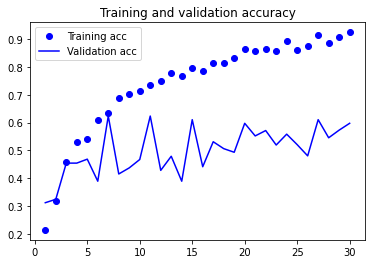

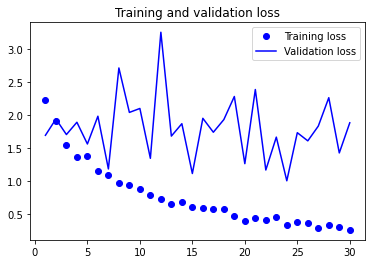

In [34]:
plotModel(model_fit_1)

*CNN model 2: Including dropout layer and one hidden layer*

In [37]:
classifier_2 = Sequential()

classifier_2.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Flatten())
classifier_2.add(Dropout(0.5))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 10, activation = 'softmax')) # number of classes

classifier_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)        

In [38]:
classifier_2.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_2 = classifier_2.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 638ms/step - loss: 2.2763 - accuracy: 0.2092 - val_loss: 2.2441 - val_accuracy: 0.2396
Epoch 2/30
22/22 [==============================] - 14s 635ms/step - loss: 2.2386 - accuracy: 0.2163 - val_loss: 2.2045 - val_accuracy: 0.3636
Epoch 3/30
22/22 [==============================] - 13s 601ms/step - loss: 2.1667 - accuracy: 0.2192 - val_loss: 2.1899 - val_accuracy: 0.2338
Epoch 4/30
22/22 [==============================] - 13s 591ms/step - loss: 2.0587 - accuracy: 0.2393 - val_loss: 2.1009 - val_accuracy: 0.2987
Epoch 5/30
22/22 [==============================] - 14s 637ms/step - loss: 1.9137 - accuracy: 0.3166 - val_loss: 2.0572 - val_accuracy: 0.3333
Epoch 6/30
22/22 [==============================] - 14s 649ms/step - loss: 1.8231 - accuracy: 0.3509 - val_loss: 1.7842 - val_accuracy: 0.3766
Epoch 7/30
22/22 [==============================] - 13s 580ms/step - loss: 1.5323 - accuracy: 0.4162 - val_loss: 2.0510 - val_accuracy: 0.3506

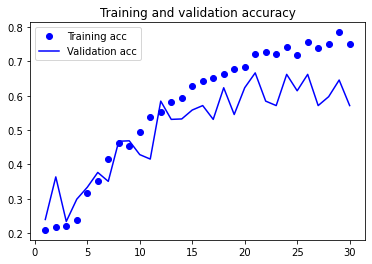

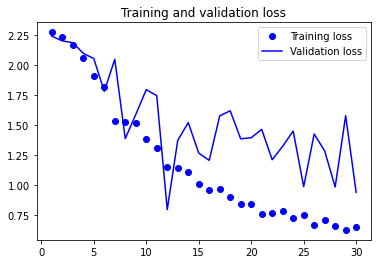

In [44]:
classifier_2.save('classifier_2.h5') #save model 
plotModel(model_fit_2)

*CNN model 3: Transfer learning from VGG16*

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))


In [51]:
classifier_3 = Sequential()
classifier_3.add(conv_base)
classifier_3.add(Flatten())
classifier_3.add(Dense(128, activation='relu'))
classifier_3.add(Dense(units = 10, activation = 'softmax'))\

classifier_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 14,978,250
Trainable params: 14,978,250
Non-trainable params: 0
_________________________________________________________________


In [52]:
classifier_3.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_3 = classifier_3.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 629ms/step - loss: 2.4907 - accuracy: 0.1991 - val_loss: 2.1140 - val_accuracy: 0.2708
Epoch 2/30
22/22 [==============================] - 14s 658ms/step - loss: 2.2417 - accuracy: 0.2034 - val_loss: 2.1403 - val_accuracy: 0.2468
Epoch 3/30
22/22 [==============================] - 13s 586ms/step - loss: 2.2686 - accuracy: 0.1862 - val_loss: 2.2321 - val_accuracy: 0.3117
Epoch 4/30
22/22 [==============================] - 13s 607ms/step - loss: 2.2073 - accuracy: 0.2178 - val_loss: 2.0747 - val_accuracy: 0.2727
Epoch 5/30
22/22 [==============================] - 14s 633ms/step - loss: 2.2042 - accuracy: 0.2344 - val_loss: 2.1041 - val_accuracy: 0.2812
Epoch 6/30
22/22 [==============================] - 14s 642ms/step - loss: 2.1767 - accuracy: 0.2269 - val_loss: 1.9589 - val_accuracy: 0.3247
Epoch 7/30
22/22 [==============================] - 13s 613ms/step - loss: 2.1011 - accuracy: 0.2472 - val_loss: 2.0942 - val_accuracy: 0.2208

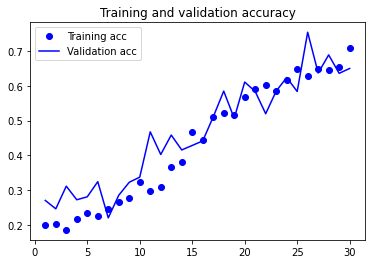

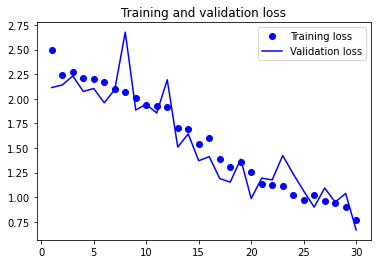

In [53]:
classifier_3.save('classifier_3.h5') #save model 
plotModel(model_fit_3)

*CNN model 4: Transfer learning from ResNet*

In [56]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [57]:
classifier_4 = Sequential()
classifier_4.add(conv_base)
classifier_4.add(Flatten())
classifier_4.add(Dense(128, activation='relu'))
classifier_4.add(Dense(units = 10, activation = 'softmax'))\

classifier_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 24,637,706
Trainable params: 24,584,586
Non-trainable params: 53,120
_________________________________________________________________


In [58]:
classifier_4.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_4 = classifier_4.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 100,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/100
22/22 [==============================] - 25s 1s/step - loss: 2.3261 - accuracy: 0.3754 - val_loss: 3.5140 - val_accuracy: 0.0729
Epoch 2/100
22/22 [==============================] - 14s 657ms/step - loss: 1.1609 - accuracy: 0.6203 - val_loss: 10.1842 - val_accuracy: 0.2597
Epoch 3/100
22/22 [==============================] - 13s 606ms/step - loss: 0.8351 - accuracy: 0.7120 - val_loss: 5.3200 - val_accuracy: 0.2468
Epoch 4/100
22/22 [==============================] - 13s 586ms/step - loss: 0.5997 - accuracy: 0.7940 - val_loss: 3.8194 - val_accuracy: 0.1558
Epoch 5/100
22/22 [==============================] - 15s 660ms/step - loss: 0.4916 - accuracy: 0.8237 - val_loss: 2.8550 - val_accuracy: 0.1562
Epoch 6/100
22/22 [==============================] - 15s 672ms/step - loss: 0.4952 - accuracy: 0.8438 - val_loss: 2.3630 - val_accuracy: 0.1039
Epoch 7/100
22/22 [==============================] - 14s 620ms/step - loss: 0.4111 - accuracy: 0.8711 - val_loss: 2.5728 - val_accuracy: 0

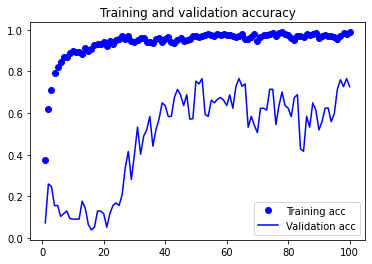

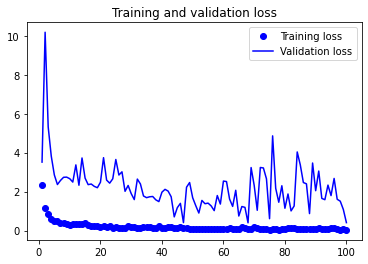

In [59]:
classifier_4.save('classifier_4.h5') #save model 
plotModel(model_fit_4)

**Dataset 2:**

**Dataset 3:**

107 classes (107 poses)
- 5353 training
- 641 testing

In [0]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset_full'

In [12]:
batch_size = 32
validation_split = 0.1
colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = split_utils.train_valid_split(DATA_DIR, validation_split, seed=1)

# generator for train data
train_datagen = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
)

# generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
    )

print('The ratio of validation_split is {}'.format(validation_split))
print('The size of train_dir is {}'.format(train_generator.n))
print('The size of val_dir is {}'.format(validation_generator.n))

Found 5353 images belonging to 107 classes.
Found 641 images belonging to 107 classes.
The ratio of validation_split is 0.1
The size of train_dir is 5353
The size of val_dir is 641


In [17]:
# Model 2: Including dropout layer
classifier_2 = Sequential()

classifier_2.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Flatten())
classifier_2.add(Dropout(0.5))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 107, activation = 'softmax')) # number of classes

classifier_2.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 128)        

In [0]:
filepath_2 = "classifier_2.h5"

logpath_2 = "Model_2_history.csv"
log_2 = CSVLogger(logpath_2, append=True)

early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=5)

checkpoint_2 = ModelCheckpoint(filepath = filepath_2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [                              
    early_stop,
    checkpoint_2,
    log_2
]

In [35]:
classifier_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])   

classifier_2.fit_generator(
          train_generator,
          steps_per_epoch= 5353 // batch_size,                             
          epochs=32,                                                      
          validation_data=validation_generator,
          validation_steps = 641 // batch_size
          callbacks = callbacks_list)

Epoch 1/30
116/167 [===================>..........] - ETA: 7:12 - loss: 4.6679 - accuracy: 0.0119

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


167/167 [==============================] - 1467s 9s/step - loss: 4.6654 - accuracy: 0.0118 - val_loss: 4.6085 - val_accuracy: 0.0140

Epoch 00001: val_accuracy improved from -inf to 0.01404, saving model to classifier_2.hdf5
Epoch 2/30
167/167 [==============================] - 45s 267ms/step - loss: 4.6498 - accuracy: 0.0148 - val_loss: 4.6704 - val_accuracy: 0.0140

Epoch 00002: val_accuracy did not improve from 0.01404
Epoch 3/30
167/167 [==============================] - 44s 263ms/step - loss: 4.6359 - accuracy: 0.0133 - val_loss: 4.5749 - val_accuracy: 0.0250

Epoch 00003: val_accuracy improved from 0.01404 to 0.02496, saving model to classifier_2.hdf5
Epoch 4/30
167/167 [==============================] - 44s 265ms/step - loss: 4.5414 - accuracy: 0.0224 - val_loss: 3.1621 - val_accuracy: 0.0468

Epoch 00004: val_accuracy improved from 0.02496 to 0.04680, saving model to classifier_2.hdf5
Epoch 5/30
167/167 [==============================] - 44s 264ms/step - loss: 4.4487 - accuracy